In [1]:
import torch
import numpy as np
from datasets import load_dataset

import tqdm
import multiprocessing as mp

import matplotlib.pyplot as plt


import torchvision.transforms as T

from phe import paillier

from crypto.modules.mlp import SimpleMLP
from torch.utils.data import DataLoader

/leonardo_work/IscrC_TVU/azirilli/crypto/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = SimpleMLP()

best_model_wts= torch.load("best_model.pth")

model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [3]:
public_key, private_key = paillier.generate_paillier_keypair()

In [4]:
# torch utils

def apply_transform(batch, transform):
    images = batch["image"]
    batch["image"] = [transform(img) for img in images]
    return batch

def collate_fn(batch):

    images = [item["image"] for item in batch]
    labels = [item["label"] for item in batch]

    images = torch.stack(images)

    labels = torch.tensor(labels, dtype=torch.long)

    return images, labels

def get_apply_transform(transform):
    return lambda x: apply_transform(x, transform)

# crypto utils

def encrypt_row(row):
    """Encrypt a single row of the matrix."""
    return [public_key.encrypt(x.item()) for x in row]

def encrypt_matrix_parallel(a):
    assert len(a.shape) == 2
    num_cpus = min(28, mp.cpu_count())
    print(f"Using {num_cpus} CPUs")

    encrypted_matrix = []

    with mp.Pool(num_cpus) as pool:
        for encrypted_row in tqdm.tqdm(pool.imap(encrypt_row, a),
                                       total=a.shape[0]):
            encrypted_matrix.append(encrypted_row)

    return encrypted_matrix

# plot utils

def plot_encrypted_matrix(enc_matrix):

    cipher_matrix = [
        [num.ciphertext() for num in row] 
        for row in enc_matrix
    ]

    img_data = np.array(
        [[val % 255 for val in row] for row in cipher_matrix], 
        dtype=float
    )

    # 3. Plot
    plt.figure(figsize=(2, 2))
    plt.imshow(img_data, cmap='gray', vmin=0, vmax=255)
    plt.title("Ciphered image (mod 255)")
    plt.axis('off')
    plt.show()


ds = load_dataset("ylecun/mnist")

Using the latest cached version of the dataset since ylecun/mnist couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'mnist' at /leonardo_scratch/fast/IscrC_USAE/.cache/ylecun___mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Wed Nov 26 14:55:47 2025).


# Let's try to normalise encrypted data

In [5]:
transform = T.Compose([
    T.ToTensor(),
])


ds.set_transform(get_apply_transform(transform))

test_loader = DataLoader(
    ds["test"],
    batch_size=256,
    shuffle=False,
    collate_fn=collate_fn
)

In [6]:
first = next(iter(test_loader))[0][0]

In [7]:
first.shape

torch.Size([1, 28, 28])

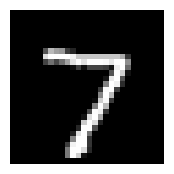

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

ax.imshow(first.squeeze(), cmap='gray')
ax.axis('off')

plt.show()

In [9]:
image = encrypt_matrix_parallel(first.squeeze())

Using 28 CPUs


100%|██████████| 28/28 [03:34<00:00,  7.65s/it]  


In [10]:
mean = -0.1307
std = 1 / 0.3081

normalised_matrix = []

for row in image:
    encrypted_row = []
    for el in row:
        # Add scalar (mean) in encrypted space
        el = el + mean   # el = el + mean
        # Multiply by std in encrypted space
        el = el * std            # el = el * std
        encrypted_row.append(el)
    normalised_matrix.append(encrypted_row)

In [11]:
torch_norm = T.Normalize((0.1307,), (0.3081,))
first_tensor = first.clone() 
normalized_torch = torch_norm(first_tensor)

In [12]:
decrypted_matrix = []

for row in normalised_matrix:
    decrypted_row = []
    for el in row:
        decrypted_row.append(private_key.decrypt(el)) 
    decrypted_matrix.append(decrypted_row)

decrypted_tensor = torch.tensor(decrypted_matrix, dtype=first.dtype)

print("Max absolute difference:", torch.max(torch.abs(decrypted_tensor - normalized_torch)))
print("Mean absolute difference:", torch.mean(torch.abs(decrypted_tensor - normalized_torch)))

Max absolute difference: tensor(2.3842e-07)
Mean absolute difference: tensor(3.9907e-08)


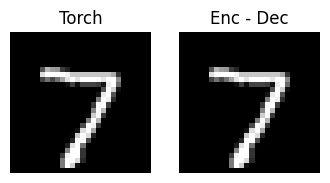

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(4, 8))

ax[0].set_title("Torch")
ax[0].imshow(normalized_torch.squeeze(), cmap='gray')
ax[0].axis('off')

ax[1].set_title("Enc - Dec")
ax[1].imshow(decrypted_tensor, cmap='gray')
ax[1].axis('off')

plt.show()

# Let's test inference on an encrypted number

In [14]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
])

ds.set_transform(get_apply_transform(transform))

test_loader = DataLoader(
    ds["test"],
    batch_size=256,
    shuffle=False,
    collate_fn=collate_fn
)

In [15]:
data_iter = iter(test_loader)
next(data_iter)
second_batch = next(data_iter)
second = second_batch[0][0]

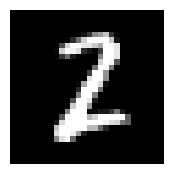

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

ax.imshow(second.squeeze(), cmap='gray')
ax.axis('off')

plt.show()

In [17]:
enc_image = encrypt_matrix_parallel(second.squeeze())

Using 28 CPUs


100%|██████████| 28/28 [03:34<00:00,  7.65s/it]  


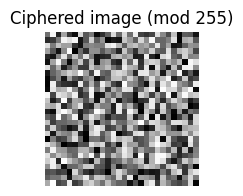

In [18]:
plot_encrypted_matrix(enc_image)

In [30]:
from functools import partial
import torch.nn as nn
import multiprocessing as mp
from tqdm import tqdm

def h_mul(row, x):
    assert len(x) == row.shape[0]
    return sum(w_val * x_val for w_val, x_val in zip(row, x))

def parallel_mul(w, x, layer="Performing mul"):
    assert len(w.shape) == 2
    w = w.detach().cpu().numpy()
    num_cpus = min(28, mp.cpu_count()) 
    
    results = []
    func = partial(h_mul, x=x)

    with mp.Pool(num_cpus) as pool:
        for result in tqdm(pool.imap(func, w), total=w.shape[0], desc=layer):
            results.append(result)

    return results

def h_add(vector, bias):
    assert len(vector) == len(bias)
    new_vector = []
    for v_val, b_val in zip(vector, bias):
        new_vector.append(v_val + b_val)
    return new_vector

def h_relu(vector):
    new_vector = []
    
    for x in vector:
        val = x * x 
        new_vector.append(val)
        
    return new_vector

class PaillerMLP(nn.Module):
    def __init__(self, mlp) -> None:
        super().__init__()
        self.mlp = mlp
        
    def forward(self, input):
        x = parallel_mul(self.mlp.layer_1.weight, input, layer="Layer 1 Mul")
        x = h_add(x, self.mlp.layer_1.bias)
        x = h_relu(x)

        x = parallel_mul(self.mlp.layer_2.weight, x, layer="Layer 2 Mul")
        x = h_add(x, self.mlp.layer_2.bias)
        x = h_relu(x)

        x = parallel_mul(self.mlp.layer_3.weight, x, layer="Layer 3 Mul")
        x = h_add(x, self.mlp.layer_3.bias)
        
        return x

pailler_mlp = PaillerMLP(model)

In [31]:
flatten_image = []
for row in enc_image:
    flatten_image.extend(row)
    
len(flatten_image)

784

In [32]:
with torch.no_grad():
    output = pailler_mlp(flatten_image)

Layer 1 Mul:  22%|██▏       | 28/128 [04:07<14:45,  8.85s/it]  


KeyboardInterrupt: 